### 1) Libraries

In [1]:
# Importing the libraries
import pandas as pd
import numpy as np
import seaborn as sns
import requests
import socket
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import bs4 as bs
import src.cleaning as src 

### 2) Getting csv dataset

In [2]:
# Getting the csv data
dataset_historic = pd.read_csv('../World-Happiness-Project2/input/dataset_happiness_historic.csv')
dataset_2019 = pd.read_csv('../World-Happiness-Project2/input/dataset_health.csv')

### 3)Web scrapping

In [3]:
# Getting some tables with web scrapping
urls = ['https://worldpopulationreview.com/country-rankings/suicide-rate-by-country',
        'https://en.wikipedia.org/wiki/List_of_countries_by_average_yearly_temperature',
        'https://en.wikipedia.org/wiki/List_of_countries_by_inequality-adjusted_Human_Development_Index']

In [4]:
# Function web scrapping
def get_table(url):
    res = requests.get(url)
    html = res.content
    soup = bs.BeautifulSoup(html, "html.parser")
    if url == 'https://en.wikipedia.org/wiki/List_of_countries_by_inequality-adjusted_Human_Development_Index':
        df = pd.read_html(html)[2]
    else:
        df = pd.read_html(html)[0]
    return df

In [5]:
dataframes = []
for i in urls:
    dataframes.append(get_table(i))

### 4) Cleaning the Data

In [6]:
# Renaming
columns = list(dataset_historic.columns)
columns[0] = 'Country'
dataset_historic.columns = columns

In [7]:
# Renaming the columns
dataframes[2].columns = ['Inequality', 'Country', 'IHDI', 'HDI', 'Overall loss (%)', 'Growth since 2010']

In [8]:
# Merging the datasets
dataframe_1 = pd.merge(dataframes[0], dataframes[1], how = "inner", on = ["Country", "Country"])
dataframe_2 = pd.merge(dataframe_1, dataframes[2], how = "inner", on = ["Country", "Country"])
dataframe_3 = pd.merge(dataframe_2, dataset_2019, how = "inner", on = ["Country", "Country"])
dataframe_4 = pd.merge(dataframe_3, dataset_historic.loc[dataset_historic['year'] == 2019], how = "inner", on = ["Country", "Country"])
dataset = dataframe_4.copy()

In [9]:
# Cleaning de dataset
dataset = dataset.dropna()


In [10]:
#functions from src
src.stand_colum_name(dataset)
src.temperature(dataset)
src.historic_to_float(dataset)
src.percent_to_float(dataset)
src.to_numeric(dataset)

In [11]:
dataset = dataset[['country', 'life ladder', 'log gdp per capita','social support', 
                   'healthy life expectancy at birth','freedom to make life choices',
                   'generosity','perceptions of corruption', 'positive affect', 
                   'negative affect', 'total suicide rate','average yearly temperature (1961–1990 celsius)', 
                   'inequality','anxiety disorders', 'drug use disorders', 
                   'depression','alcohol use disorders']]

In [12]:
dataset.columns= ['country', 'life ladder', 'gdp per capita', 'social support',
       'life expectancy', 'freedom to make choices',
       'generosity', 'corruption', 'positive affect',
       'negative affect', 'total suicide rate',
       'average temperature', 'inequality',
       'anxiety disorders', 'drug use', 'depression',
       'alcohol use']


### 5) Plotting

#### 5.1) Map

In [13]:
# Dataframe plottly
df = px.data.gapminder()
df_depara = df[['country', 'continent', 'iso_alpha', 'iso_num']]

In [14]:
# Adding features
continents = []
iso_alpha = []
iso_num = []

for i in range(len(dataset_historic)):
    country = dataset_historic.iloc[i]['Country']
    try:
        continents.append(df_depara.loc[df_depara['country'] == country]['continent'].values[0])
    except:
        continents.append('No data')
    try:
        iso_alpha.append(df_depara.loc[df_depara['country'] == country]['iso_alpha'].values[0])
    except:
        iso_alpha.append('No data')
    try:
        iso_num.append(df_depara.loc[df_depara['country'] == country]['iso_num'].values[0])
    except:
        iso_num.append('No data')

dataset_historic['continent'] = continents
dataset_historic['iso_alpha'] = iso_alpha
dataset_historic['iso_num'] = iso_num

In [15]:
# Filtering
dataset_mapa = dataset_historic.loc[(dataset_historic['continent'] != "No Data") & (dataset_historic['iso_alpha'] != "No Data") & (dataset_historic['iso_num'] != "No Data")]

In [16]:
# Cleaning
dataset_mapa = dataset_mapa.dropna()

for i in dataset_mapa.columns:
    try:
        dataset_mapa[i] = dataset_mapa[i].apply(lambda x: float(x.replace(",", ".")))
    except:
        pass

In [45]:
# Columns to plot
numeric_columns = ['Life Ladder', 'Log GDP per capita', 'Social support', 'Healthy life expectancy at birth', 'Freedom to make life choices', 'Generosity', 'Perceptions of corruption', 'Positive affect', 'Negative affect']
print('Choose one from the following:')
for i in numeric_columns:
    print(i, end = '\n')
column = input()

Choose one from the following:
Life Ladder
Log GDP per capita
Social support
Healthy life expectancy at birth
Freedom to make life choices
Generosity
Perceptions of corruption
Positive affect
Negative affect
Perceptions of corruption


In [46]:
# Plotando
fig = px.scatter_geo(dataset_mapa, locations="iso_alpha", color="Life Ladder",
                     hover_name="Country", size=column,
                     animation_frame="year",
                     projection="natural earth")

fig.update_layout(width = 1000, title = f'How "{column}" ao longo dos anos')

#### 5.2) Correlation

In [19]:
dataset_happy=dataset.drop(['total suicide rate', 'average temperature', 'inequality',
       'anxiety disorders', 'drug use', 'depression', 'alcohol use'], axis=1)

In [20]:
dataset_happy.columns

Index(['country', 'life ladder', 'gdp per capita', 'social support',
       'life expectancy', 'freedom to make choices', 'generosity',
       'corruption', 'positive affect', 'negative affect'],
      dtype='object')

<AxesSubplot:>

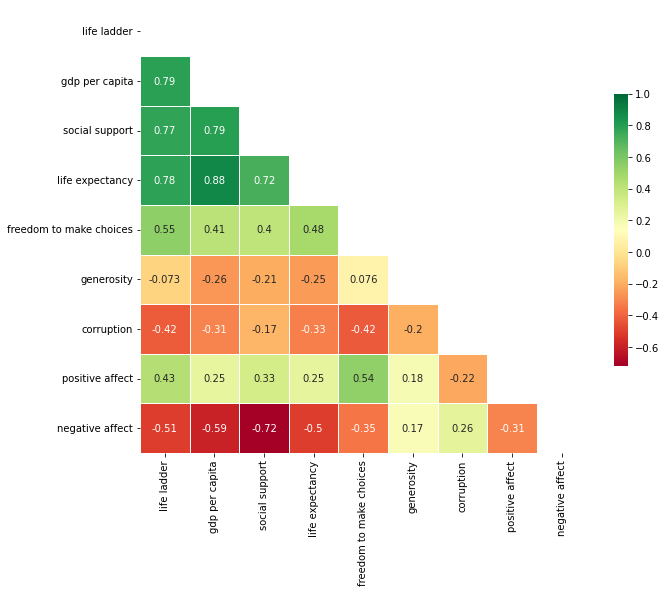

In [21]:
corrmat = dataset_happy[1:].corr()
mask = np.triu(np.ones_like(corrmat, dtype=bool)) 
top_corr_features = corrmat.index
plt.figure(figsize = (10, 10))

sns.heatmap(corrmat,  
            mask = mask,
            cmap='RdYlGn',
            square=True, 
            linewidth=0.5, 
            annot = True,
            vmax=1,
            cbar_kws={"shrink": .5})



In [43]:
dataset_new_var=dataset.drop(['gdp per capita', 'social support',
       'life expectancy', 'freedom to make choices', 'generosity',
       'corruption', 'positive affect', 'negative affect'], axis=1)

<AxesSubplot:>

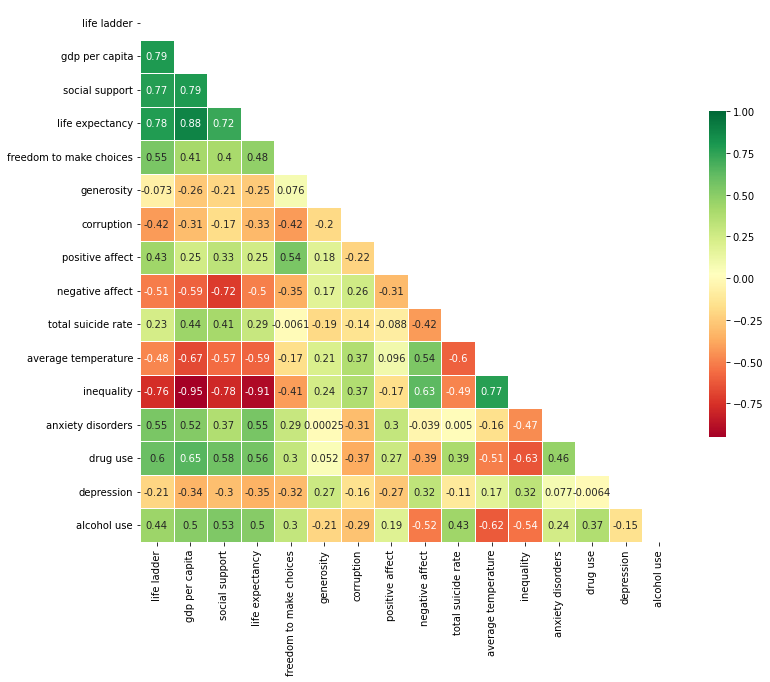

In [22]:
corrmat = dataset[1:].corr()
mask = np.triu(np.ones_like(corrmat, dtype=bool)) 
top_corr_features = corrmat.index
plt.figure(figsize = (12, 12))

sns.heatmap(corrmat,  
            mask = mask,
            cmap='RdYlGn',
            square=True, 
            linewidth=0.5, 
            annot = True,
            vmax=1,
            cbar_kws={"shrink": .5})


#### 5.3) Scattermatrix

In [23]:
# Filtering the dataset
dataset_filter = dataset.drop(['country','gdp per capita','social support','life expectancy',
                               'freedom to make choices','generosity','corruption',
                               'positive affect','negative affect'], axis = 1)

In [42]:
# Creating world happines repport scatter
dataset_filter_2 = dataset[['life ladder', 'gdp per capita','social support','life expectancy',
                               'freedom to make choices','generosity','corruption',
                               'positive affect','negative affect']]

fig = px.scatter_matrix(dataset_filter_2)
fig.update_layout(width = 1500, height = 1400)
fig.show()

In [25]:
# Scatter matrix - happyness - mental health variables
fig = px.scatter_matrix(dataset_filter)
fig.update_layout(width = 1500, height = 1400)
fig.show()

#### 6.4) Deep dive

In [26]:
dataset_dist = pd.read_csv('../World-Happiness-Project2/output/dataset.csv')

<AxesSubplot:xlabel='life ladder', ylabel='Density'>

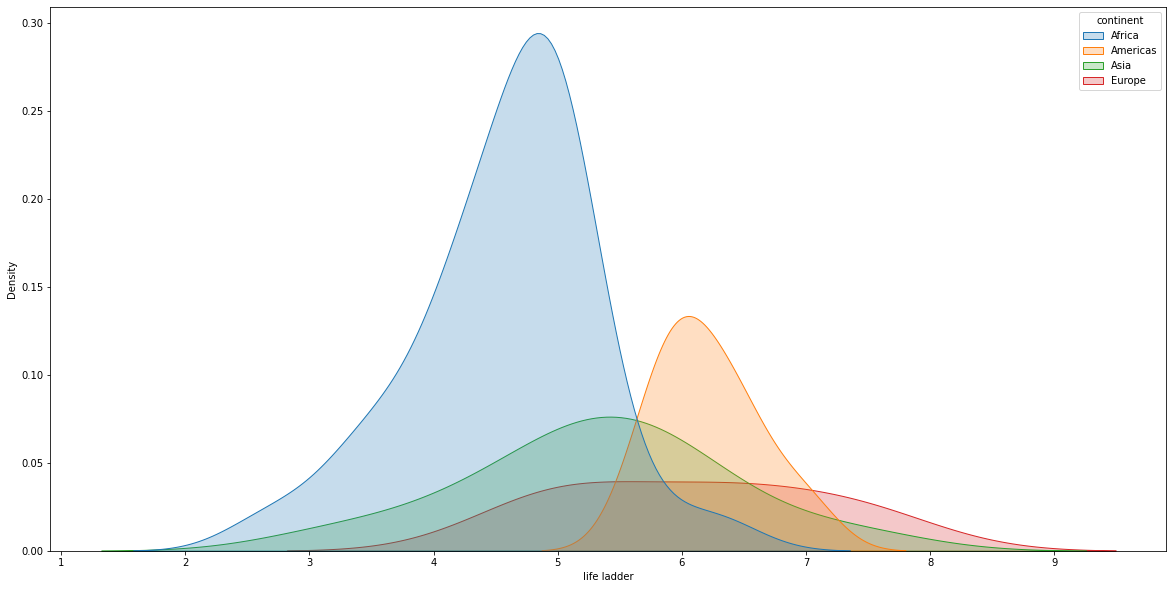

In [27]:
# life ladder x continent
plt.figure(figsize = (20, 10))
sns.kdeplot(x=dataset_dist.loc[dataset_dist['continent'] != "No data"]['life ladder'], hue=dataset_dist.loc[dataset_dist['continent'] != "No data"]['continent'], fill=True)

<AxesSubplot:xlabel='freedom to make life choices', ylabel='Density'>

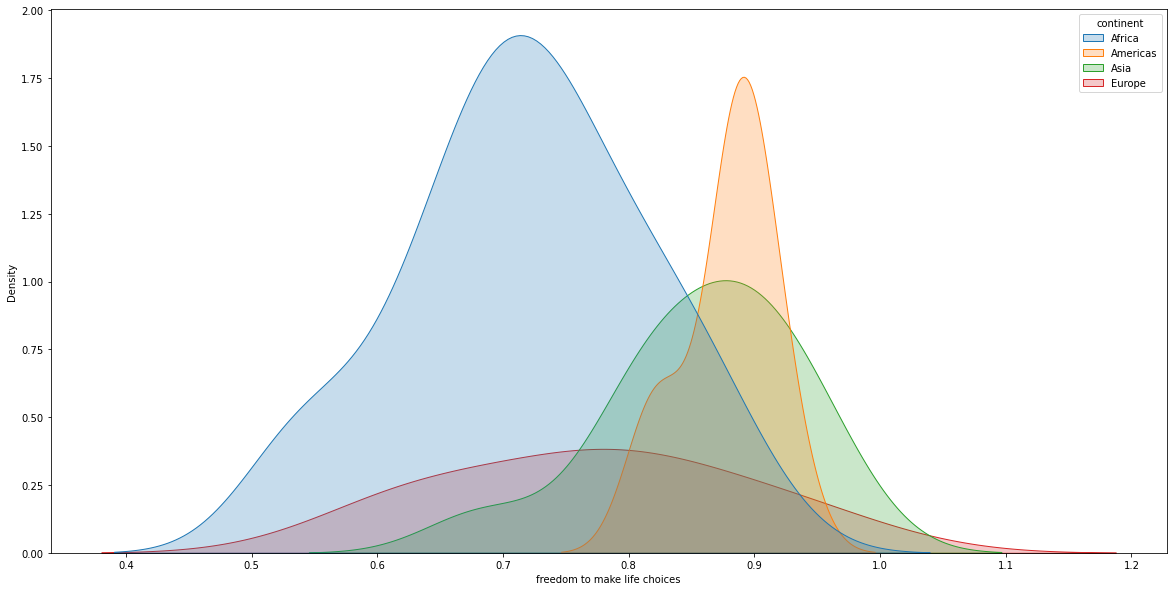

In [28]:
# freedom to make life choices
plt.figure(figsize = (20, 10))
sns.kdeplot(x=dataset_dist.loc[dataset_dist['continent'] != "No data"]['freedom to make life choices'], hue=dataset_dist.loc[dataset_dist['continent'] != "No data"]['continent'], fill=True)

<AxesSubplot:xlabel='social support', ylabel='Density'>

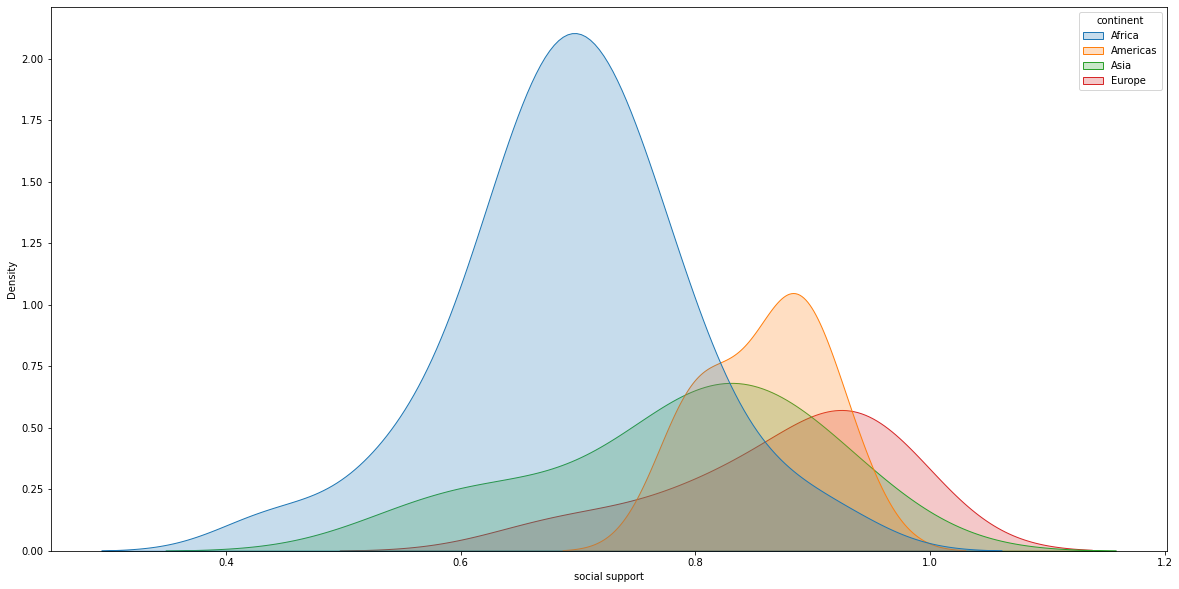

In [29]:
# social support
plt.figure(figsize = (20, 10))
sns.kdeplot(x=dataset_dist.loc[dataset_dist['continent'] != "No data"]['social support'], hue=dataset_dist.loc[dataset_dist['continent'] != "No data"]['continent'], fill=True)

<AxesSubplot:xlabel='log gdp per capita', ylabel='Density'>

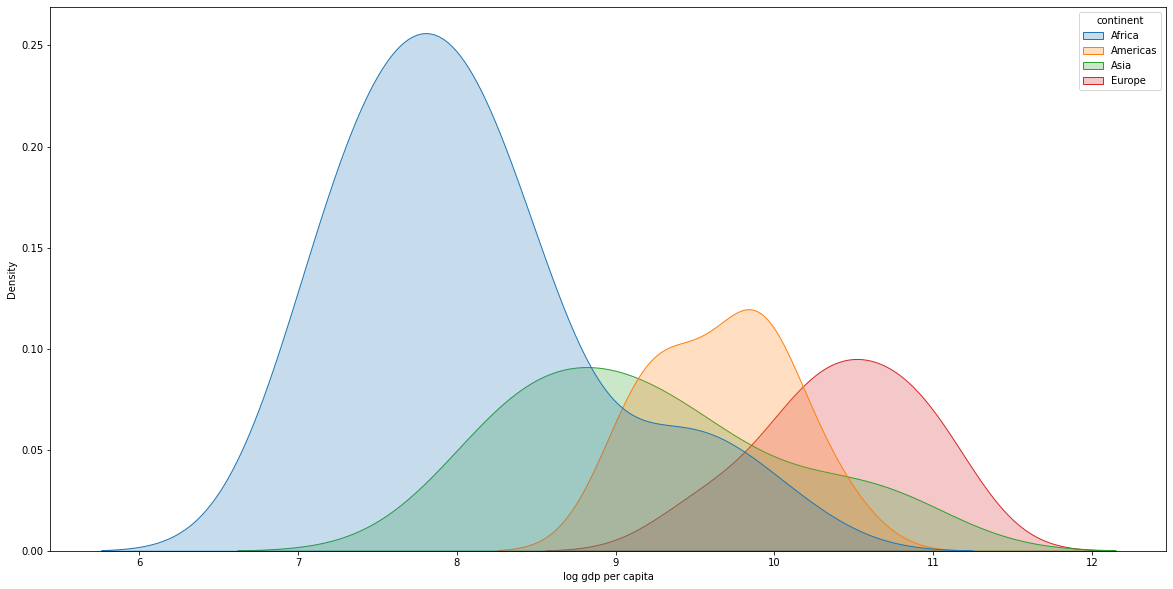

In [30]:
# log gdp per capita
plt.figure(figsize = (20, 10))
sns.kdeplot(x=dataset_dist.loc[dataset_dist['continent'] != "No data"]['log gdp per capita'], hue=dataset_dist.loc[dataset_dist['continent'] != "No data"]['continent'], fill=True)

<AxesSubplot:xlabel='healthy life expectancy at birth', ylabel='Density'>

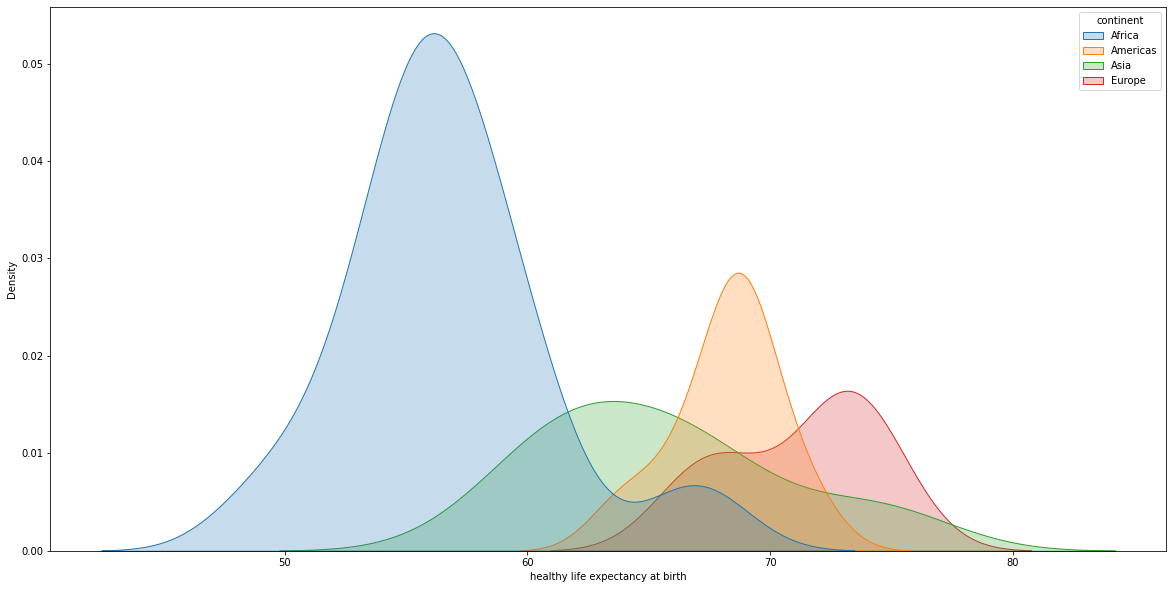

In [31]:
# healthy life expectancy at birth
plt.figure(figsize = (20, 10))
sns.kdeplot(x=dataset_dist.loc[dataset_dist['continent'] != "No data"]['healthy life expectancy at birth'], hue=dataset_dist.loc[dataset_dist['continent'] != "No data"]['continent'], fill=True)

<AxesSubplot:xlabel='perceptions of corruption', ylabel='Density'>

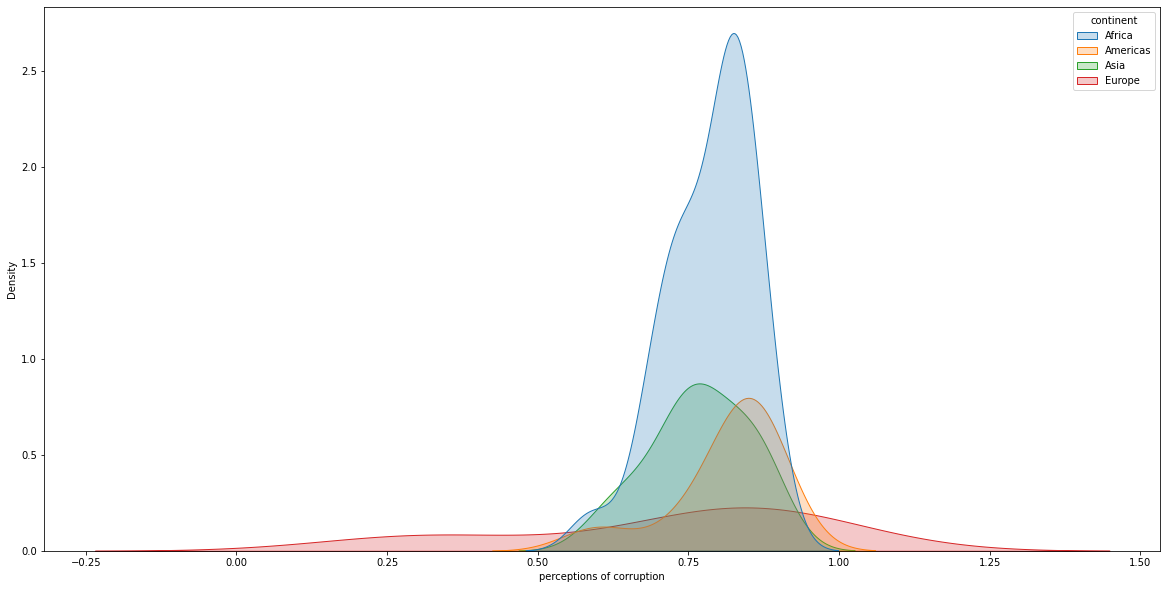

In [32]:
# perceptions of corruption
plt.figure(figsize = (20, 10))
sns.kdeplot(x=dataset_dist.loc[dataset_dist['continent'] != "No data"]['perceptions of corruption'], hue=dataset_dist.loc[dataset_dist['continent'] != "No data"]['continent'], fill=True)

#### 6.5) Analysis

In [33]:
# Clean
dataset = dataset.loc[(dataset['total suicide rate'] < 70) & (dataset['drug use'] < 2)]

In [34]:
# life ladder x total suicide rate
fig = px.scatter(dataset, x="life ladder", y="total suicide rate", trendline = 'ols',trendline_color_override="red")
fig.update_layout(width = 1000, height = 500)
fig.show()

In [35]:
# life ladder x average yearly temperature (1961–1990 celsius)
fig = px.scatter(dataset, x="life ladder", y="average temperature", trendline = 'ols', trendline_color_override="red")
fig.update_layout(width = 1000, height = 500)
fig.show()

In [36]:
# life ladder x inequality
fig = px.scatter(dataset, x="life ladder", y="inequality", trendline = 'ols', trendline_color_override="red")
fig.update_layout(width = 1000, height = 500)
fig.show()

In [37]:
# life ladder x anxiety disorders
fig = px.scatter(dataset, x="life ladder", y="anxiety disorders", trendline = 'ols', trendline_color_override="red")
fig.update_layout(width = 1000, height = 500)
fig.show()

In [38]:
# life ladder x drug use disorders
fig = px.scatter(dataset, x="life ladder", y="drug use", trendline = 'ols', trendline_color_override="red")
fig.update_layout(width = 1000, height = 500)
fig.show()

In [39]:
# life ladder x depression
fig = px.scatter(dataset, x="life ladder", y="depression", trendline = 'ols', trendline_color_override="red")
fig.update_layout(width = 1000, height = 500)
fig.show()

In [40]:
# life ladder x alcohol use disorders
fig = px.scatter(dataset, x="life ladder", y="alcohol use", trendline = 'ols', trendline_color_override="red")
fig.update_layout(width = 1000, height = 500)
fig.show()